In [3]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 20)

<br>

# Functions

In [4]:
def M2Q(df_in):
    d = {"M03":"Q1", "M06":"Q2", "M09":"Q3", "M12":"Q4"}
    df_out = df_in[df_in['TIME'].apply(lambda x: x[-3:] in list(d.keys()))].copy()
    df_out.TIME = df_out['TIME'].apply(lambda x: x[:4]+d[x[-3:]]).copy()
    return(df_out)

def Qp1(df_in):
    d = {"Q1":"Q2", "Q2":"Q3", "Q3":"Q4", "Q4":"Q1"}
    df_out = df_in.copy()
    df_out.TIME = df_out['TIME'].apply(lambda x: str(int(x[:-2])+1)+d[x[-2:]] if x[-1:] == "4" else x[:-2]+d[x[-2:]]).copy()
    return(df_out)

<br>

# Data

In [5]:
path = "./data/csvs/"
!sed -i "s/://g" ./data/*

#!head -n 1 data/une_rt_q_Label.csv

>## Quarterly

In [6]:
# DATASET Construction - quarterly data - index (2015 = 100) (NACE Rev. 2) [ei_isbu_q]
ei_isbu_q = pd.read_csv("./data/ei_isbu_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
ei_isbu_q_lag = Qp1(ei_isbu_q.copy())

# DATASET Final consumption aggregates [namq_10_fcs]
namq_10_fcs = pd.read_csv("./data/namq_10_fcs_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
namq_10_fcs_lag = Qp1(namq_10_fcs.copy())

# DATASET: GDP and main components  (output, expenditure and income) [namq_10_gdp]
namq_10_gdp = pd.read_csv("./data/namq_10_gdp_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
namq_10_gdp_lag = Qp1(namq_10_gdp.copy())

# DATASET Building permits - quarterly data [sts_cobp_q]
sts_cobp_q = pd.read_csv("./data/sts_cobp_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_cobp_q_lag = Qp1(sts_cobp_q.copy())

# DATASET Production in construction - quarterly data [sts_copr_q]
sts_copr_q = pd.read_csv("./data/sts_copr_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_copr_q_lag = Qp1(sts_copr_q.copy())

# DATASET Production in industry - quarterly data [sts_inpr_q]
sts_inpr_q = pd.read_csv("./data/sts_inpr_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_inpr_q_lag = Qp1(sts_inpr_q.copy())

# DATASET Turnover in industry, total - quarterly data [sts_intv_q]
sts_intv_q = pd.read_csv("./data/sts_intv_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_intv_q_lag = Qp1(sts_intv_q.copy())

# DATASET Turnover and volume of sales in wholesale and retail trade - quarterly data [sts_trtu_q]
sts_trtu_q = pd.read_csv("./data/sts_trtu_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_trtu_q_lag = Qp1(sts_trtu_q.copy())

# DATASET: Unemployment by sex and age - quarterly average [une_rt_q]
une_rt_q = pd.read_csv("./data/une_rt_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
une_rt_q_lag = Qp1(une_rt_q.copy())

>## Monthly

In [7]:
# DATASET Euro-zone Business Climate Indicator - monthly data [ei_bsci_m_r2]
ei_bsci_m_r2_1 = M2Q(pd.read_csv("./data/ei_bsci_m_r2_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

# DATASET Sentiment indicators - monthly data [ei_bssi_m_r2]
ei_bssi_m_r2 = M2Q(pd.read_csv("./data/ei_bssi_m_r2_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

# DATASET Effective exchange rates indices - monthly data [ei_mfef_m]
ei_mfef_m = M2Q(pd.read_csv("./data/ei_mfef_m_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

**Dealing with ids:**

In [9]:
for df in [ei_isbu_q, ei_isbu_q_lag, namq_10_fcs, namq_10_fcs_lag, namq_10_gdp, 
           namq_10_gdp_lag, sts_cobp_q, sts_cobp_q_lag, sts_copr_q, sts_copr_q_lag, 
           sts_inpr_q, sts_inpr_q_lag, sts_intv_q, sts_intv_q_lag, sts_trtu_q, 
           sts_trtu_q_lag, ei_isbu_q, ei_isbu_q_lag, namq_10_fcs, namq_10_fcs_lag, 
           namq_10_gdp, namq_10_gdp_lag, sts_cobp_q, sts_cobp_q_lag, sts_copr_q, sts_copr_q_lag, 
           sts_inpr_q, sts_inpr_q_lag, sts_intv_q, sts_intv_q_lag, sts_trtu_q, sts_trtu_q_lag, ei_bsci_m_r2_1, ei_bssi_m_r2, ei_mfef_m, une_rt_q]:
    df["ID"] = df["TIME"]+df["GEO"]
    df.Value = df.Value.replace(regex=r'[,]+', value='').astype(np.float)

># OECD

In [10]:
def OECD():
    GEO_LABEL2GEO = dict(zip(namq_10_gdp.GEO_LABEL.values, namq_10_gdp.GEO.values)); GEO_LABEL2GEO["Germany"] = "DE"
    df_in = pd.read_csv("data/KEI_13112018143436794_[v1-oecd].csv")
    df_in["GEO"] = df_in.Country.map(GEO_LABEL2GEO)
    df_in = df_in[df_in.GEO.notnull()]
    df_in["ID"] = df_in.TIME.str[:4]+df_in.TIME.str[-2:]+df_in.GEO
    return(df_in)

In [13]:
OECD0 = OECD()

TypeError: 'DataFrame' object is not callable

<br>

# $C$

>## $Cd$

In [10]:
def Cd(model_variables=[], version=0, all_boolean=False, country_dummies=True):
    df_in = pd.DataFrame(sorted(list(set(namq_10_fcs.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P311_S14")&(namq_10_fcs_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Retail Confidence Indicator
    var = "BS-RCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Services Confidence Indicator
    var = "BS-SCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Consumer Confidence Indicator
    var = "BS-CSMCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - Durable Consumer Goods
    var = "MIG_DCOG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacture of motor vehicles, trailers, semi-trailers and of other transport equipment
    # Checked - UNIT I15
    var = "C29_C30"
    if var in model_variables or all_boolean:
        selec = sts_intv_q[(sts_intv_q.NACE_R2==var)&(sts_intv_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Harmonised unemployment rate all persons, s.a.
    var = "LRHUTTTT"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Passenger car registrations, s.a.
    var = "SLRTCR03"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_fcs.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Cd = df_in.dropna().copy(); Cd.set_index("ID", inplace=True)
    Cd = Cd.loc[:, (Cd != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Cd.to_csv("./regressions/Cd"+str(version)+".csv")
        
    ###########################################################################################
    
    # Regression
    X = sm.add_constant(Cd.loc[:, Cd.columns != "CLV_PCH_SM"].copy())
    y = Cd.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(Cd, results)

In [11]:
Cd1, Cd1_results = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL"], 1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     41.82
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          1.26e-144
Time:                        16:57:06   Log-Likelihood:                -5697.7
No. Observations:                1590   AIC:                         1.144e+04
Df Residuals:                    1566   BIC:                         1.157e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.6867      1.146      4.964   

In [12]:
Cd2, Cd2_results = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL", "SLRTCR03", "C29_C30"], 2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     51.95
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          5.33e-148
Time:                        16:57:07   Log-Likelihood:                -3873.9
No. Observations:                1118   AIC:                             7792.
Df Residuals:                    1096   BIC:                             7902.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.0236      2.056      2.443   

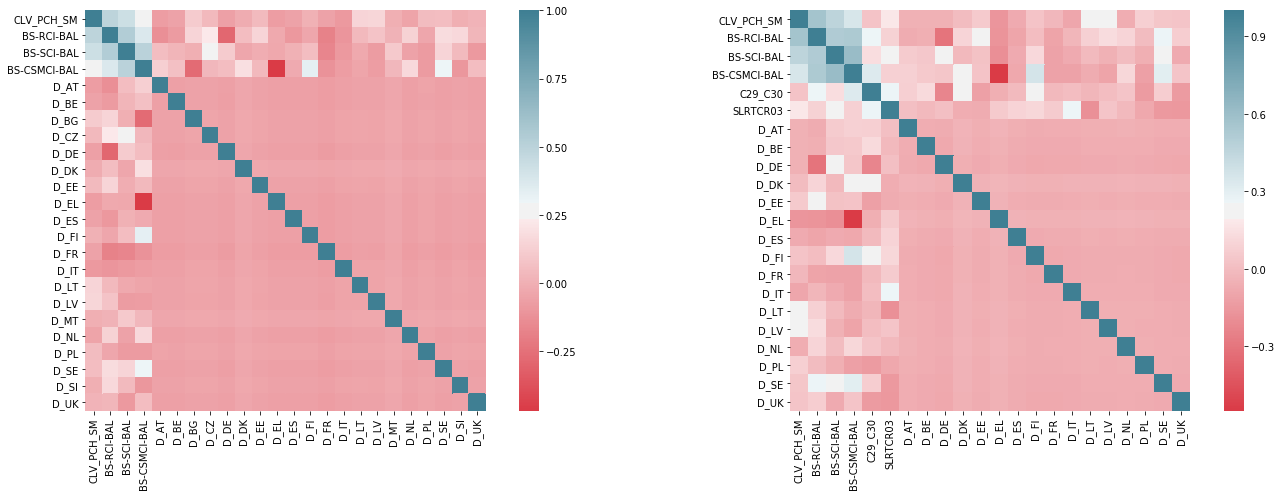

In [13]:
f, axes = plt.subplots(1, 2, figsize=(20, 7)); axes = axes.flatten()
sns.heatmap(Cd1.corr(), mask=np.zeros_like(Cd1.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=axes[0]);
sns.heatmap(Cd2.corr(), mask=np.zeros_like(Cd2.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=axes[1])
plt.tight_layout();

In [14]:
Cd3, Cd3_results = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL", "SLRTCR03", "C29_C30", "CLV_PCH_PRE"], 3)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     77.26
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          8.26e-205
Time:                        16:57:09   Log-Likelihood:                -3736.3
No. Observations:                1118   AIC:                             7519.
Df Residuals:                    1095   BIC:                             7634.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1473      1.822      1.727   

In [15]:
Cd_all, Cd_all_results = Cd(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     68.37
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          2.38e-201
Time:                        16:57:09   Log-Likelihood:                -3647.4
No. Observations:                1092   AIC:                             7347.
Df Residuals:                    1066   BIC:                             7477.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.9315      3.412     -1.152   

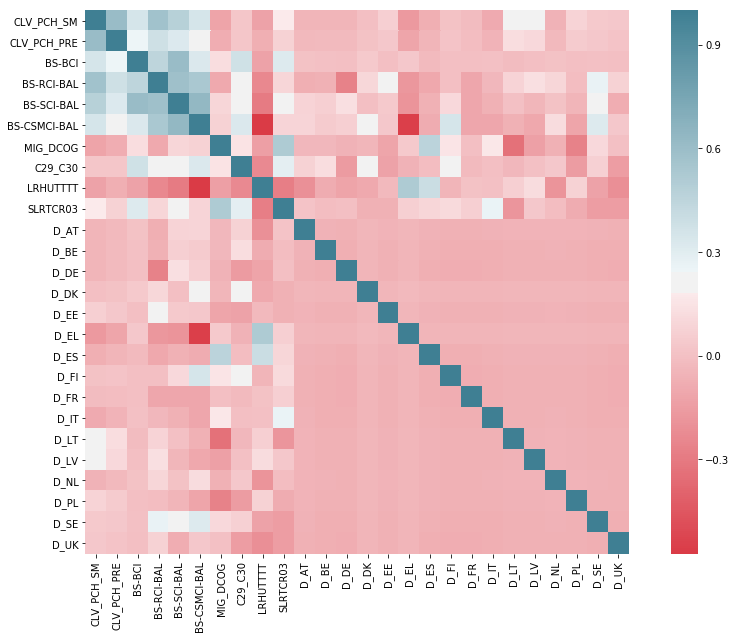

In [42]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(Cd_all.corr(), mask=np.zeros_like(Cd_all.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

>## $Cnd$

In [16]:
def Cnd(model_variables=[], version=0, all_boolean=False, country_dummies=True):

    df_in = pd.DataFrame(sorted(list(set(namq_10_fcs.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P312N_S14")&(namq_10_fcs_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    # Checked - no changes
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Retail Confidence Indicator
    # Checked - no changes
    var = "BS-RCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Services Confidence Indicator
    # Checked - no changes
    var = "BS-SCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Consumer Confidence Indicator
    # Checked - no changes
    var = "BS-CSMCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - Non-Durable Consumer Goods
    var = "MIG_NDCOG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail sale of food, beverages and tobacco
    # Checked - UNIT I15
    var = "G47_FOOD"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[(sts_trtu_q.NACE_R2==var)&(sts_trtu_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail sale of non-food products (except fuel)
    # Checked - UNIT I15
    var = "G47_NFOOD_X_G473"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[(sts_trtu_q.NACE_R2==var)&(sts_trtu_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail trade, except of motor vehicles, motorcyles and fuel
    # Checked - UNIT I15
    var = "G47_X_G473"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[(sts_trtu_q.NACE_R2==var)&(sts_trtu_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Harmonised unemployment rate all persons, s.a.
    var = "LRHUTTTT"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_fcs.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Cnd = df_in.dropna().copy().set_index("ID")
    Cnd = Cnd.loc[:, (Cnd != 0).any(axis=0)].copy()
    
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Cnd.to_csv("./regressions/Cnd"+str(version)+".csv")
    
    ###########################################################################################
    
    # Regression
    X = sm.add_constant(Cnd.loc[:, Cnd.columns != "CLV_PCH_SM"].copy())
    y = Cnd.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(Cnd, results)

In [17]:
Cnd1, Cnd1_results = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD"], 1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     51.86
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          2.29e-172
Time:                        16:57:10   Log-Likelihood:                -3518.8
No. Observations:                1541   AIC:                             7086.
Df Residuals:                    1517   BIC:                             7214.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.7840      0.579  

In [18]:
Cnd2, Cnd2_results = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD", "BS-SCI-BAL", "LRHUTTTT"], 2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     68.91
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          1.82e-198
Time:                        16:57:10   Log-Likelihood:                -2796.1
No. Observations:                1292   AIC:                             5638.
Df Residuals:                    1269   BIC:                             5757.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.3469      0.998  

In [19]:
Cnd3, Cnd3_results = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD", "BS-SCI-BAL", "LRHUTTTT", "CLV_PCH_PRE"], 3)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     133.0
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          6.21e-318
Time:                        16:57:10   Log-Likelihood:                -2510.9
No. Observations:                1292   AIC:                             5070.
Df Residuals:                    1268   BIC:                             5194.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.2058      0.816  

In [20]:
Cnd_all, Cnd_all_results = Cnd(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     113.6
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          9.45e-309
Time:                        16:57:11   Log-Likelihood:                -2408.5
No. Observations:                1239   AIC:                             4873.
Df Residuals:                    1211   BIC:                             5016.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.5587      1.267  

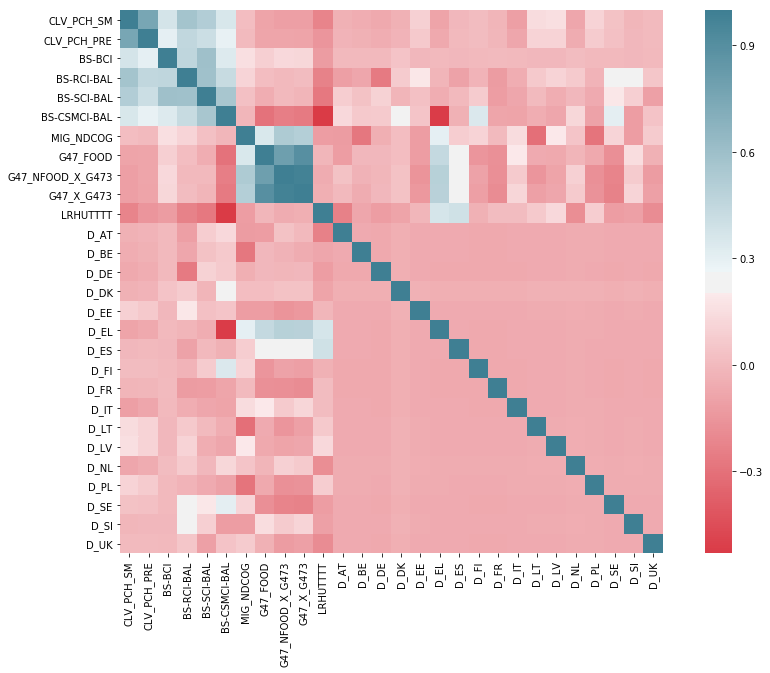

In [43]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(Cnd_all.corr(), mask=np.zeros_like(Cnd_all.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

<br>

# $I$

>## $Igfcf$

In [21]:
def Igfcf(model_variables=[], version=0, all_boolean=False, country_dummies=True):
    
    df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ## Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P51G")&(namq_10_gdp_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Industrial Confidence Indicator
    var = "BS-ICI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Building permits index - New residential buildings
    # Checked - UNIT I2015
    var = "IS-PEI"
    if var in model_variables or all_boolean:
        selec = ei_isbu_q[(ei_isbu_q.INDIC==var)&(ei_isbu_q.UNIT=="I2015")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Residential buildings, except residences for communities
    # Checked - UNIT I15  
    var = "F_CC11_X_CC113"
    if var in model_variables or all_boolean:
        selec = sts_cobp_q[(sts_cobp_q.NACE_R2==var)&(sts_cobp_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Two- and more dwelling buildings
    # Checked - UNIT I15
    var = "F_CC112"
    if var in model_variables or all_boolean:
        selec = sts_cobp_q[(sts_cobp_q.NACE_R2==var)&(sts_cobp_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Construction confidence indicator
    var = "BS-CCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Volume index of production
    # Checked - UNIT I15
    var = "PROD"
    if var in model_variables or all_boolean:
        selec = sts_copr_q[(sts_copr_q.INDIC_BT==var)&(sts_copr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - energy (except Section E)
    # Checked - UNIT I15
    var = "MIG_NRG_X_E"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - capital goods
    # Checked - UNIT I15
    var = "MIG_CAG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Mining and quarrying; manufacturing
    # Checked - UNIT I15
    var = "B_C"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Mining and quarrying; manufacturing (except MIG energy)
    # Checked - UNIT I15
    var = "B_C_X_MIG_NRG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Manufacturing
    # Checked - UNIT I15
    var = "C"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", "C_prod"]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Electricity, gas, steam and air conditioning supply
    # Checked - UNIT I15
    var = "D"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacture of motor vehicles, trailers, semi-trailers and of other transport equipment
    # Checked - UNIT I15
    var = "C29_C30"
    if var in model_variables or all_boolean:
        selec = sts_intv_q[(sts_intv_q.NACE_R2==var)&(sts_intv_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacturing
    # Checked - UNIT I15
    var = "C"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_gdp.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Igfcf = df_in.dropna().copy().set_index("ID")
    Igfcf = Igfcf.loc[:, (Igfcf != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Igfcf.to_csv("./regressions/Igfcf"+str(version)+".csv")
    
    ###########################################################################################
    
    # Regression
    X = sm.add_constant(Igfcf.loc[:, Igfcf.columns != "CLV_PCH_SM"].copy())
    y = Igfcf.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(Igfcf, results)

In [22]:
Igfcf1, Igfcf1_results = Igfcf(["BS-BCI", "BS-BCI", "B_C_X_MIG_NRG"],1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     15.40
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           4.06e-61
Time:                        16:57:11   Log-Likelihood:                -6869.1
No. Observations:                1785   AIC:                         1.379e+04
Df Residuals:                    1758   BIC:                         1.394e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0089      2.472      0.004

In [23]:
Igfcf2, Igfcf2_results = Igfcf(["BS-BCI", "BS-BCI", "B_C_X_MIG_NRG","C29_C30", "BS-CCI-BAL"],2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     55.04
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          2.25e-177
Time:                        16:57:11   Log-Likelihood:                -4901.3
No. Observations:                1432   AIC:                             9851.
Df Residuals:                    1408   BIC:                             9977.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.4056      2.066      9.875

In [24]:
Igfcf3, Igfcf3_results = Igfcf(["BS-BCI", "BS-BCI", "B_C_X_MIG_NRG","C29_C30", "BS-CCI-BAL", "CLV_PCH_PRE"],3) 

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     66.94
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          1.13e-212
Time:                        16:57:12   Log-Likelihood:                -4815.2
No. Observations:                1432   AIC:                             9680.
Df Residuals:                    1407   BIC:                             9812.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            17.5840      1.958      8.981

In [25]:
Igfcf_all, Igfcf_all_resuls = Igfcf(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     40.71
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          1.11e-166
Time:                        16:57:12   Log-Likelihood:                -4149.1
No. Observations:                1229   AIC:                             8364.
Df Residuals:                    1196   BIC:                             8533.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             21.6705      3.183      6.

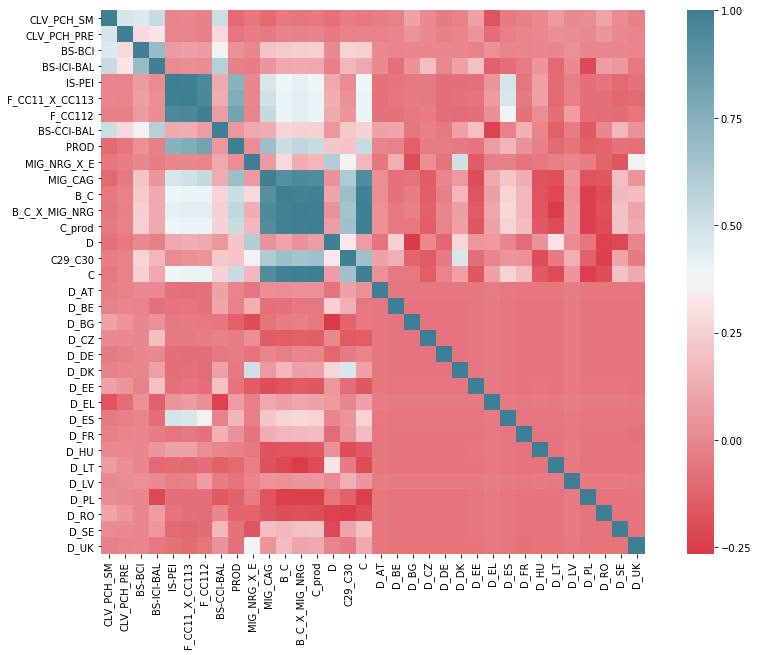

In [44]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(Igfcf_all.corr(), mask=np.zeros_like(Igfcf_all.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

<br>

# $G$

$$G_t = \textit{Purchases of Goods and Services}_t+ \textit{Wages Public Servants}_t+ \textit{Investment}_t$$
The value calculated is -0.0086575.

<br>

# $X$

In [26]:
def X(model_variables=[], version=0, all_boolean=False, country_dummies=True):

    ext_tec03 = pd.read_csv("./data/ext_tec03_1_Data.csv"); ext_tec03.Value = ext_tec03.Value.replace(regex=r'[,]+', value='').astype(np.float)
    XXX_source = ext_tec03[(ext_tec03.TIME==2016)& (ext_tec03.STK_FLOW=="EXP")]
    XXX_countries = sorted(list(set(ext_tec03.GEO.values)))
    XXX_matrix = pd.DataFrame(index=XXX_countries, columns=XXX_countries)
    for ind, row in XXX_source.iterrows():
        if row.GEO == row.PARTNER:
            XXX_matrix.loc[row.GEO][row.PARTNER]=0
        else:
            XXX_matrix.loc[row.GEO][row.PARTNER]=row.Value#/np.sum(XXX_source[XXX_source.GEO==row.GEO].Value)
    XXX_matrix = XXX_matrix.dropna()
    XXX_matrix = XXX_matrix[XXX_matrix.index.values].copy()
    XXX_weights = XXX_matrix.divide(XXX_matrix.sum(axis=1), axis=0).copy()
    countries = sorted(list(XXX_weights.index.values))
    
    ###########################################################################################
    
    df_in = pd.DataFrame(index = sorted(list(set(namq_10_gdp.ID))))
    
    ###########################################################################################

    ## Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    for country in countries:
        selec = namq_10_gdp[((namq_10_gdp.NA_ITEM=="B1GQ")&(namq_10_gdp.UNIT=="CLV_PCH_SM"))&(namq_10_gdp.GEO==country)][["TIME", "Value"]]
        temp_dict = dict(zip(selec.TIME.values, selec.Value.values))
        df_in[country] = df_in.index.str[:-2].map(temp_dict)
                
    for ID in df_in.index:
        if ID[-2:] in XXX_weights.index:
            df_in.at[ID,:] = df_in.loc[ID,:].values*XXX_weights.loc[ID[-2:],:].values
        else:
            #print(ID)
            df_in.drop(ID, axis=0, inplace=True)
    df_in = df_in.loc[:,df_in.notna().sum()!=0].dropna().copy()
    df_in.index.name = "ID"; df_in.reset_index(inplace=True)

    ###########################################################################################

    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P6")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
        # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
        
    # Economic sentiment indicator
    var = "BS-ESI-I"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Real Effective Exchange Rate (deflator consumer price indices - 42 trading partners)
    var = "REER42CPI"
    if var in model_variables or all_boolean:
        selec = ei_mfef_m[ei_mfef_m.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries.remove('PT')
        for country in sorted(list(countries)):
            df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)

    ###########################################################################################

    X = df_in.dropna().copy().set_index("ID")
    X = X.loc[:, (X != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        X.to_csv("./X"+version+".csv")
    
    ###########################################################################################
    
    # Regression
    X_mat = sm.add_constant(X.loc[:, X.columns != "CLV_PCH_SM"].copy())
    y = X.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X_mat).fit()
    print(results.summary())
    
    return(X, results)

In [27]:
X0, X0_results = X(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     39.80
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          3.09e-235
Time:                        16:57:47   Log-Likelihood:                -5375.1
No. Observations:                1716   AIC:                         1.085e+04
Df Residuals:                    1668   BIC:                         1.111e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.5620      3.422     -3.671      0.0

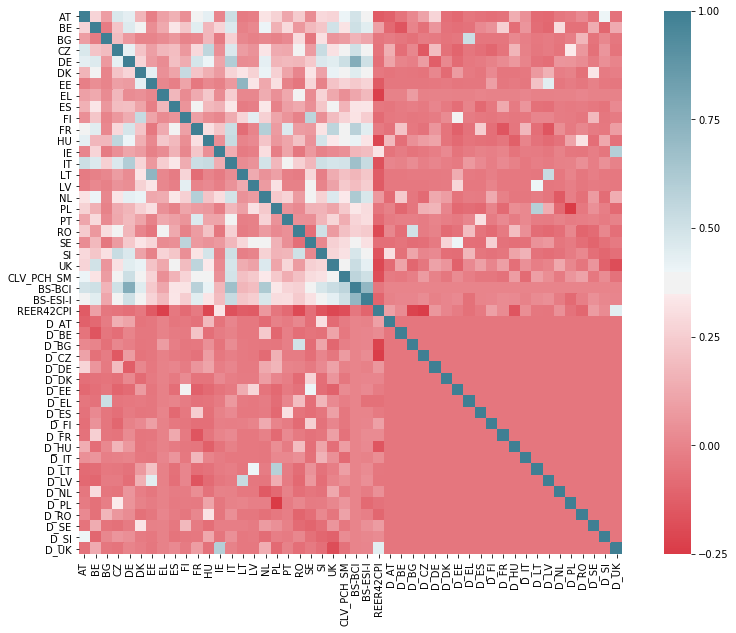

In [45]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(X0.corr(), mask=np.zeros_like(X0.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

<br>

# $M$

In [32]:
def M():
    
    df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])

    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P7")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "M"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cd
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cnd
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # G
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Igfcf
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Economic sentiment indicator
    var = "BS-ESI-I"
    selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Real Effective Exchange Rate (deflator consumer price indices - 42 trading partners)
    var = "REER42CPI"
    selec = ei_mfef_m[ei_mfef_m.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    
    #############################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P7")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "M"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cd
    selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cnd
    selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # G
    selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Igfcf
    selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    countries = set(namq_10_gdp.GEO); countries.remove('PT')
    for country in sorted(list(countries)):
        df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    M = df_in.copy().set_index("ID")
    M = M.loc[:, (M != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    M.to_csv("./M.csv")
    
    ###########################################################################################
    
    # Regression
    X = sm.add_constant(M.loc[:, M.columns != "M"].copy())
    y = M.loc[:, "M"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(M, results)

In [33]:
M0, M0_results = M()

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     145.9
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:00:47   Log-Likelihood:                -4934.1
No. Observations:                1701   AIC:                             9934.
Df Residuals:                    1668   BIC:                         1.011e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.3136      2.343     -5.255      0.0

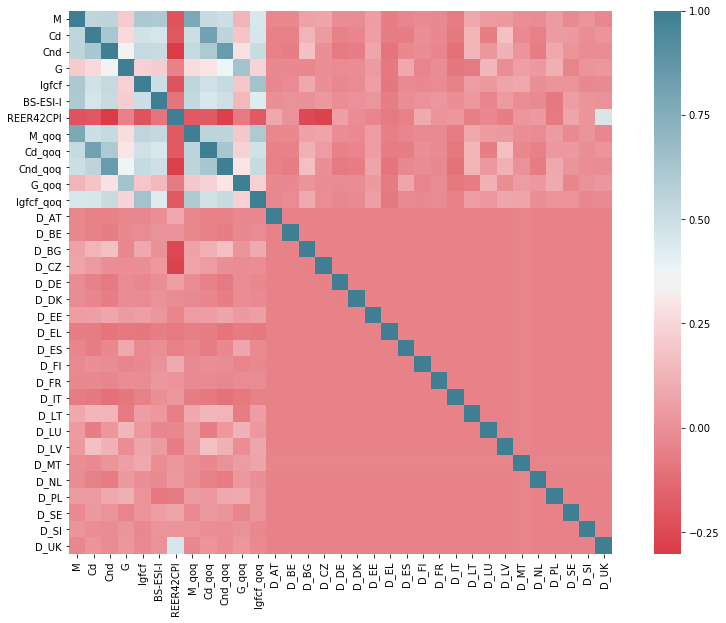

In [46]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(M.corr(), mask=np.zeros_like(M.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

<br>

____________________

<br>

# Looking at the Labor Market

In [42]:
def LaborMarket():
    
    df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])

    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    df_in = pd.DataFrame(sorted(list(set(une_rt_q.ID))), columns=["ID"])
    var = "SA"
    selec = une_rt_q[(une_rt_q.UNIT=="PC_ACT")&(une_rt_q.S_ADJ==var)][["ID", "Value"]]; selec.columns = ["ID", "U"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cd
    var = "CLV_PCH_SM"
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cnd
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # G
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Igfcf
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Economic sentiment indicator
    var = "BS-ESI-I"
    selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Real Effective Exchange Rate (deflator consumer price indices - 42 trading partners)
    var = "REER42CPI"
    selec = ei_mfef_m[ei_mfef_m.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    #############################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P7")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "M"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cd
    selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cnd
    selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # G
    selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Igfcf
    selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    countries = set(namq_10_gdp.GEO); countries.remove('PT')
    for country in sorted(list(countries)):
        df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    U = df_in.copy().set_index("ID")
    U = U.loc[:, (U != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    U.to_csv("./U.csv")
    
    ###########################################################################################
    
    # Regression
    X = sm.add_constant(U.loc[:, U.columns != "U"].copy())
    y = U.loc[:, "U"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(U, results)

In [43]:
U0, U0_results = LaborMarket()

                            OLS Regression Results                            
Dep. Variable:                      U   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     104.4
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        18:53:04   Log-Likelihood:                -3950.5
No. Observations:                1692   AIC:                             7967.
Df Residuals:                    1659   BIC:                             8146.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0473      1.370     21.933      0.0

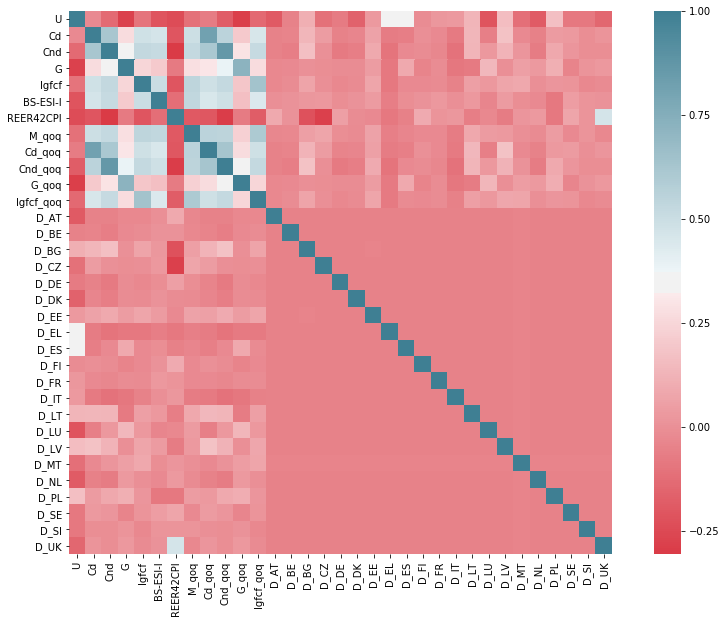

In [44]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(U0.corr(), mask=np.zeros_like(U0.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

_______________________

# Prepare to $\textbf{R}$

In [29]:
# namq_10_gdp
selec = namq_10_gdp[(namq_10_gdp.GEO == "PT") & (namq_10_gdp.UNIT == "CLV10_MEUR")]
for item in list(set(selec.NA_ITEM)):
    selec[selec.NA_ITEM==item][["TIME", "Value"]].to_csv("R/"+item+".csv", index=False)
##

# namq_10_fcs

<br>